In [1]:
from sys import stderr

from queue import LifoQueue as stack
from queue import PriorityQueue as p_queue
from queue import SimpleQueue as queue

# It seems like these structures can keep "garbage" fro
# previous runs, so we must clean them out before using:
def gc(queue):
    if not queue.empty():
        while not queue.empty():
            queue.get()

# The adjacency list graph
The following indicates the simple structure used for our graphs. The following shows a graph with nodes 0,1,2,3,4,5,6 and directed edges: $0\to 1$ with weight 1, $0\to 2$ with weight 2, etc. 

In [2]:
ToyGraph = {0 : {1:1, 2:1},
     1 : {3:8},
     2 : {4:2},
     3 : {4:1, 6:2},
     4 : {5:2, 3:5},
     5 : {3:1, 4:2},
     6 : {}}

# Visualizing graphs: `showGraph`
We can visualize our graphs using the networkx module. We need to load a few modules and convert our adjacency list graph to a networkx graph. This is done below in the following code which may be ignored. Things are set up to indicate the DFS ('blue'), the BFS solution ('red'), and the UCS solution ('green') some basic attempt has been made to indicte when the path overlay each other. 

In [239]:
import networkx as nx
import pylab as plt
import pydot as pdot

from IPython.core.display import HTML, display

#import pygraphviz
#from networkx.drawing.nx_agraph import graphviz_layout

def adjToNxGraph(G, digraph=True):
    """
    Converts one of our adjacency "list" representations for a graph into
    a networkx graph.
    """
    if digraph:
        Gr = nx.DiGraph()
    else:
        Gr = nx.Graph()

    for node in G:
        Gr.add_node(node)
        if G[node]:
            for adj in G[node]:
                Gr.add_edge(node, adj)
                Gr[node][adj]['weight'] = G[node][adj]
    return Gr

def showGraph(G, start, goal, paths = [], labels = None, 
              node_pos = 'neato', gsize = (14,14), save_file=None, digraph=True):
    """
    paths should be an array of which paths to show: 'bfs', 'dfs', 'ucs', 'astar'
    """
        
    fig, ax = plt.subplots(figsize=gsize)

    # Conver G into structure used in networkx
    Gr = adjToNxGraph(G, digraph=digraph)

    if node_pos is 'project_layout':
        # The project graphs have a particular structure.
        node_pos = dict(zip(Gr.nodes(),[(b, 9 - a) for a,b in Gr.nodes()]))
    else:
        node_pos = nx.nx_pydot.graphviz_layout(Gr, prog=node_pos, root=start)
        

    edge_weight=nx.get_edge_attributes(Gr,'weight')
    
    
    def path_edges(path):
        edges = list(zip(path[:-1], path[1:]))
        cost = sum([Gr[z[0]][z[1]]['weight'] for z in edges])
        if not digraph:
            edges += list(zip(path[1:], path[:-1]))
        return edges, cost
    
    # Process Paths:
    if 'bfs' in paths:
        bpath = getPath(bdfs(G, start, goal, search ='bfs'), start, goal)
        bedges, bcost = path_edges(bpath)
    else:
        bpath = []
        bedges = []
    
    if 'dfs' in paths:
        dpath = getPath(bdfs(G, start, goal, search = 'dfs'), start, goal)
        dedges, dcost = path_edges(dpath)
    else:
        dpath = []
        dedges = []
    
    if 'ucs' in paths:
        ucost, back = ucs(G, start, goal)
        upath = getPath(back, start, goal)
        uedges, ucost = path_edges(upath)
    else:
        upath = []
        uedges = []
        

    node_col = ['orange'  if node in upath
                          else 'purple' if node in bpath and node in dpath
                          else 'blue'   if node in dpath
                          else 'red'    if node in bpath
                          else 'lightgray' for node in Gr.nodes()]

    if labels: 
        nodes = nx.draw_networkx_nodes(Gr, node_pos, ax = ax, node_color=node_col, node_size=400)
        nodes.set_edgecolor('k')
    else:
        nodes = nx.draw_networkx_nodes(Gr, node_pos, ax = ax, node_color=node_col, node_size=50)

    if labels:
        mapping = dict(zip(Gr.nodes,labels))
        nx.draw_networkx_labels(Gr, node_pos, labels=mapping, ax = ax, font_size = 8)

    edge_col = ['purple' if edge in bedges and edge in dedges
                else 'blue'   if edge in dedges 
                else 'red'    if edge in bedges 
                else 'orange' if edge in uedges else 'gray' for edge in Gr.edges()]
  
    edge_width = [3 if edge in dedges or edge in bedges or edge in uedges else 1 for edge in Gr.edges()]


    nx.draw_networkx_edge_labels(Gr, node_pos, ax = ax, edge_color=edge_col, edge_labels=edge_weight)
    nx.draw_networkx_edges(Gr, node_pos, ax = ax, edge_color=edge_col, width=edge_width, alpha=.3)
    
    if save_file:
        plt.savefig(save_file)
    
    plt.show()
    
    result = "DFS gives a path of length {} with cost {}<br>".format(len(dpath) - 1, dcost) if 'dfs' in paths else "" 
    result += "BFS gives a path of length {} with cost {}. BFS always returns a minimal length path.<br>".format(len(bpath) - 1, bcost) if 'bfs' in paths else "" 
    result += "UCS gives a path of length {} with cost {}. UCS alway returns a minimal cost path.".format(len(upath) - 1, ucost) if 'ucs' in paths else ""

    display(HTML(result))  # Need display in Jupyter

# Display initial toy graph

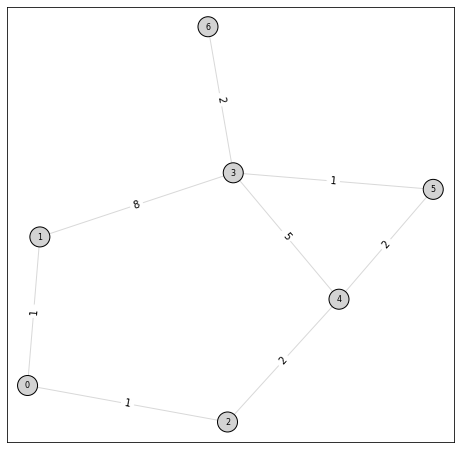

In [43]:
showGraph(ToyGraph,0,4,gsize=(8,8))

# Basic Depth First Search and Breath First Search
Here these are implemented using a basic stack (DFS) and queue (BFS). Often the goal is simply to answer "Is there a path between the start node and the goal node?", but sometimes we also wish to get hold of an actual path, for this a *back pointer* structure is introduced. When we expand the fringe at the current node we indicate for each new element of the fringe where it came from, a dictionary is used for this as well. A path can then be reconstructed backwards starting at the current element and working back to the start node which indicates the history of what nodes were expended to reach the current node. In this way a complete search tree can be reconstructed from the back pointer structure.

In [183]:
def bdfs(G, start, goal, search = 'dfs'):
    """
    This is a template. Taking fringe = stack() gives DFS and 
    fringe = queue() gives BFS. We need to add a priority function
    to get UCS. 
    
    Usage: back_pointer = bdfs(G, start, goal, fringe = stack()) (this is dfs)
           back_pointer = bdfs(G, start, goal, fringe = queue()) (this is bfs)
    """
    
    # There is actually a second subtle difference between stack and queue and that
    # has to do with when one revises the pack_pointer. Essentially, this amounts to 
    # defining a priority function where queue prioritizes short paths, fat search trees
    # while dfs prioritizes long paths, skinny search trees.
    depth = {}
         
    if search is 'dfs':
        fringe = stack()
        weight = -1 # We are pretending all edges have weight -1
    else:
        fringe = queue()
        weight = 1  # We are pretending all edges have weight 1    
         
    gc(fringe) # Make sure there is no garbage in the fringe
    
    closed = set()
    back_pointer = {}
    current = start
    depth[start] = 0
    fringe.put(current)
    
    while True:
        # If the fringe becomes empty we are out of luck
        if fringe.empty():
            print("There is no path from {} to {}".format(start, goal), file=stderr)
            return None
        
        # Get the next closed element of the closed set. This is complicated
        # by the fact that our queue has no delete so items that are already
        # in the closed set might still be in the queue. We must make sure not
        # to choose such an item.
        while True:
            current = fringe.get()  
            if current not in closed:
                break
            if fringe.empty():
                print("There is no path from {} to {}".format(start, goal), file=stderr)
                return None
        
        # Add current to the closed set
        closed.add(current)
        
        # If current is the goal we are done.
        if current == goal:
            return back_pointer
        
        # Add nodes adjacent adjacent to current to the fringe
        # provided they are not in the closed set.
        if G[current]:  # Check if G[current] != {}, bool({}) = False 
            for node in G[current]:
                if node not in closed:
                    node_depth = depth[current] + weight
                    if node not in depth or node_depth < depth[node]:
                        back_pointer[node] = current
                        depth[node] = node_depth
                    fringe.put(node)
                    
def dfs(G, start, goal):
    return bdfs(G, start, goal, search = 'dfs')

def bfs(G, start, goal):
    return bdfs(G, start, goal, search = 'bfs')

The following reconstructs the path from the back pointers. 

In [174]:
def getPath(backPointers, start, goal):
    current = goal
    s = [current]
    while current != start:
        current = backPointers[current]
        s += [current]
        
    return list(reversed(s))

# Run BFS and DFS on toy graph

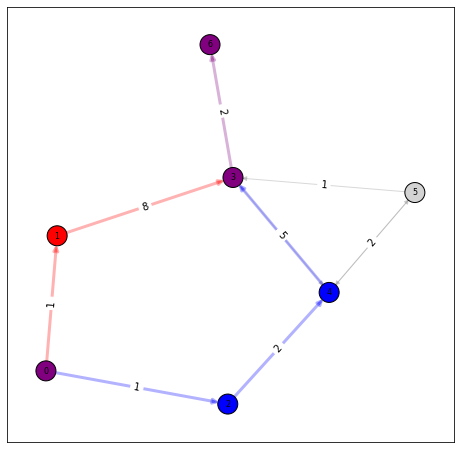

In [175]:
showGraph(ToyGraph,0,6,paths=['bfs','dfs'],gsize=(8,8))

# Random graphs

The following make is easy to try out our algorithms on random graphs. There is a probability $p$ chance that the i -> j in this graph, where $0\leq p \leq 1$. A weight function can be provided to put weights on edges.

In [176]:
from random import random as rand
from random import randint as randi

def genRandDiGraph(n, p = .5, weights = lambda i,j: 1, digraph=True):
   
    G = {}  # Initialize empty graph.
    
    for i in range(n):
        G.setdefault(i, {})
        if digraph:
            for j in range(n):
                if rand() < p and j != i:
                    # Simply choose whether or not to put
                    # a directed edge j -> i
                    G[i][j] = weights(i,j)
        else:
            for j in range(i + 1, n):
                # In case G[j] has not been initiated
                G.setdefault(j,{}) 
                if rand() < p:
                    # Simply choose whether or not to put
                    # an directed edge j -> i
                    G[i][j] = weights(i,j) 
                    G[j][i] = G[i][j]
                
    return G

Play around with different weight functions. If you do not assign a weght function, all weights default to 1 and you can verify that BFS and UCS return shortes lenth paths, since now shortest length and minimal cost are the same. Setting weighs to -1, i.e. `weights = lambda i,j: -1` is interesting as UCS then wants to find a maximal "length" path. You can set `digraph=True` or `digraph=False` and see what the difference is.

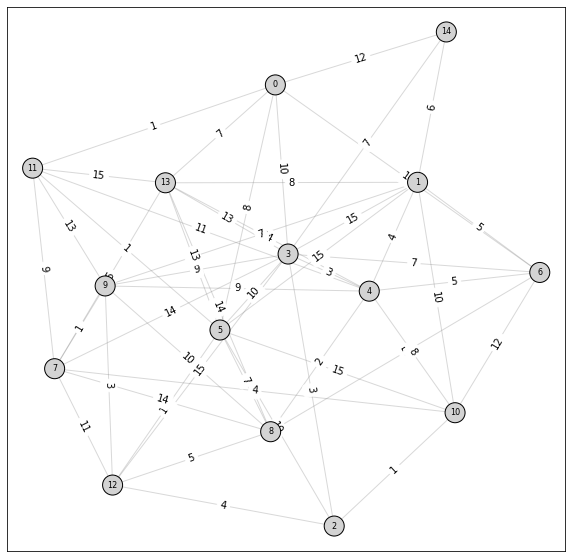

In [192]:
RandomG = genRandDiGraph(15, .4, weights=lambda i,j : randi(1, 15), digraph=False)
showGraph(RandomG, 4, 3, gsize=(10,10), digraph=False)

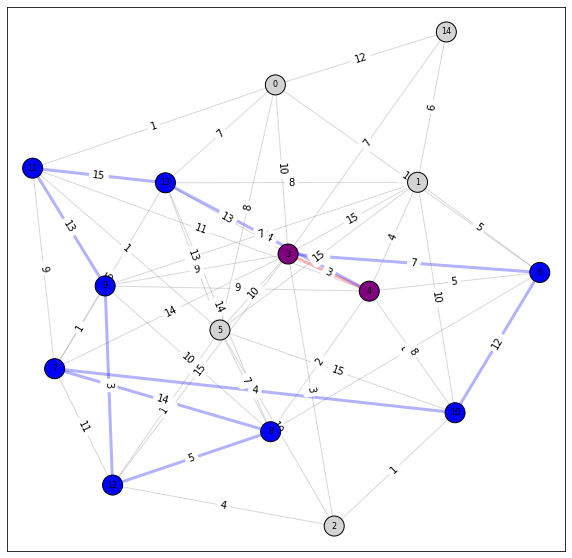

In [193]:
showGraph(RandomG, 4, 3, paths=['bfs','dfs'], gsize=(10,10), digraph=False)


# Uniform Cost Search (UCS) and $A^*$-Search
Here we must switch from regular queue and stack to the priority queue and introduce the cost function. Often the goal is simply to get the least cost of a path, but sometimes we wish to have the path itself so we keep track of back pointers as in the BFS/DFS so we can reconstuct the path. UCS is gauranteed to produce a path of minimal cost.

$A^*$ search is much like UCS, the only difference is that an additional heuristic is used to modify the priority function, so that the cost function and the priority function are no longer the same. For example, in the "project" graphs below, an additional $P(\text{node}) = P(\text{current}) + \text{cost}(\text{current}, \text{node}) + h(\text{node})$ might be used as the priority where $h(\text{node})$ is the Manhatten distance from the node to the goal. This can prevent some unecessary exploration in irrelevant directions. We won't implement $A^*$ search here.

In [167]:
def ucs(G, start, goal):
    """
    This returns the least cost of a path from start to goal or reports
    the non-existence of such path. This also retuns a pack_pointer from
    which the search tree can be reconstructed as well as all paths explored
    including the one of interest.
    
    Usage: cost, back_pointer = ucs(Graph, start, goal)
    """
    
    # Make sure th queue is empty. (Bug in implementation?)
    fringe = p_queue()
    gc(fringe)
    
    # If we did not care about the path, only the cost we could 
    # omit this block.
    cost = {}  # If all we want to do is solve the optimization
    back_pointer = {}  # problem, neither of these are necessary.
    cost[start] = 0
    # End back_pointer/cost block
    
    current = start
    fringe.put((0, start)) # Cost of start node is 0
    closed = set()
    
    while True:
        # If the fringe becomes empty we are out of luck
        if fringe.empty():
            print("There is no path from {} to {}".format(start, goal), file=stderr)
            return None
        
        # Get the next closed element of the closed set. This is complicated
        # by the fact that our queue has no delete so items that are already
        # in the closed set might still be in the queue. We must make sure not
        # to choose such an item.
        while True:
            current_cost, current = fringe.get()  
            if current not in closed:
                # Add current to the closed set
                closed.add(current)
                break
            if fringe.empty():
                print("There is no path from {} to {}".format(start, goal), file=stderr)
                return None


        # If current is the goal we are done.
        if current == goal:
            return current_cost, back_pointer
          
        # Add nodes adjacent to current to the fringe
        # provided they are not in the closed set.
        if G[current]:  # Check if G[current] != {}, bool({}) = False 
            for node in G[current]:
                if node not in closed:
                    node_cost = current_cost + G[current][node]
                    
                    # Note this little block could be removed if we only
                    # cared about the final cost and not the path
                    if node not in cost or cost[node] > node_cost:
                        back_pointer[node] = current
                        cost[node] = node_cost
                    # End of back/cost block.
                    
                    fringe.put((node_cost, node))       

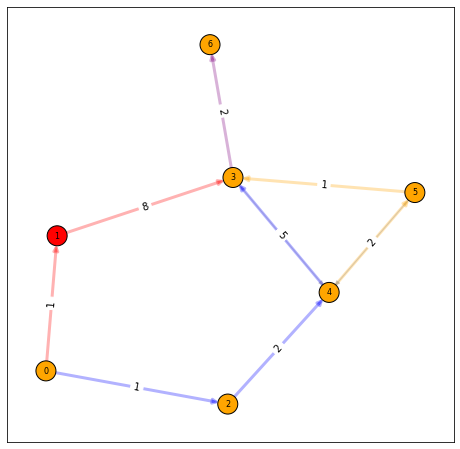

In [180]:
showGraph(ToyGraph, 0, 6, paths=['bfs','dfs','ucs'], gsize=(8,8))

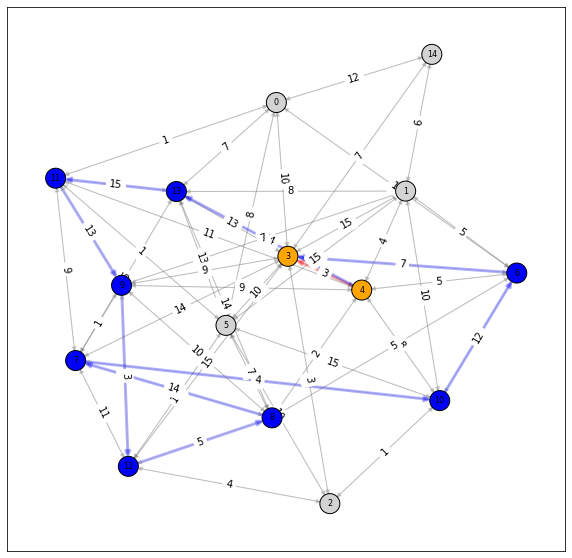

In [194]:
showGraph(RandomG, 4, 3, paths=['bfs','dfs','ucs'], gsize=(10,10))

# Project Graphs
Here we generate the sort of graphs used in the project.

In [17]:
from random import choices
import numpy as np

def genWeights(n, m, MIN, MAX, radius = 1, block_prob = 0):
    """
    This generates an instance of our problem of size mxn with integer entries roughly from
    MIN to MAX with some Inf's is block_prob is non-zero.
    """
    rng = list(range(MIN, MAX + 1)) + [np.infty]
    prbs =  [(1 - block_prob)/(len(rng) - 1) if i < len(rng) - 1 else block_prob for i in range(len(rng))]
    wts = np.random.choice(rng, (m,n), p=prbs)
    wts_smoothed = np.array(wts) # This makes a new copy
    for i in range(m):
        for j in range(n):
            tmp = wts[max(i-radius,0):min(i+radius+1,m),max(j-radius,0):min(j+radius+1,n)]
            if rand() < 0.3:
                wts_smoothed[i,j] = np.mean(tmp[tmp != np.infty])
            else:
                wts_smoothed[i,j] = np.mean(tmp)
    
    return np.round(wts_smoothed)

# Generate an instance 

Generate a 10x10 instance of our problem using values between 1 and 15. I have opted to omit any 'inf' nodes in the generation and decided to add them in as a smiley face. You could make a bigger case, say 100 x 100 and design the masking array so you get a "weighted" maze.

In [18]:
wts = genWeights(10, 10, 0, 30, radius=1, block_prob=0)
smile = np.array([
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 1, 1, 0, 0, 1, 1, 0, 0], 
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 1], 
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0], 
    [0, 0, 1, 1, 1, 1, 1, 1, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
])
wts[smile == 1] = np.infty

# Function to show project matrix: `showProjectMatrix`

In [238]:
def showProjectMatrix(wts, save_file=None):
    fig, ax = plt.subplots()

    ax.axis('off')

    wts_ = np.array(wts)
    wts_[wts == np.infty] = np.max(wts[wts != np.infty]) + 3
    ax.matshow(wts_, cmap='binary')

    for (i, j), z in np.ndenumerate(wts):
        ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')
    
    if save_file:
        plt.savefig(save_file) 
        
    plt.show()

Let's look at one representation of our problem.

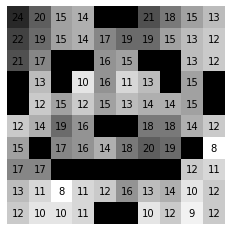

In [196]:
showProjectMatrix(wts)

# Function to convert instance into graph: `wtsToGraph`

In [20]:
def wtsToGraph(wts):
    G = {}
    m, n = wts.shape
    for i in range(m):
        for j in range(n):
            if wts[i, j] == np.infty:
                continue
            node = (i, j)
            G[node] = {}
            if wts[i, j] != np.infty:
                if i > 0 and wts[i - 1, j] != np.infty:
                    G[node][(i - 1, j)] = (wts[i - 1, j] + wts[i, j]) / 2 
                if j > 0 and wts[i, j - 1] != np.infty:
                    G[node][(i, j - 1)] = (wts[i, j - 1] + wts[i, j]) / 2
                if i < m - 1 and wts[i + 1, j] != np.infty:
                    G[node][(i + 1, j)] = (wts[i + 1, j] + wts[i, j]) / 2
                if j < n - 1 and wts[i, j + 1] != np.infty:
                    G[node][(i, j + 1)] = (wts[i, j + 1] + wts[i, j]) / 2 
    return G

# Convert the instance into a graph

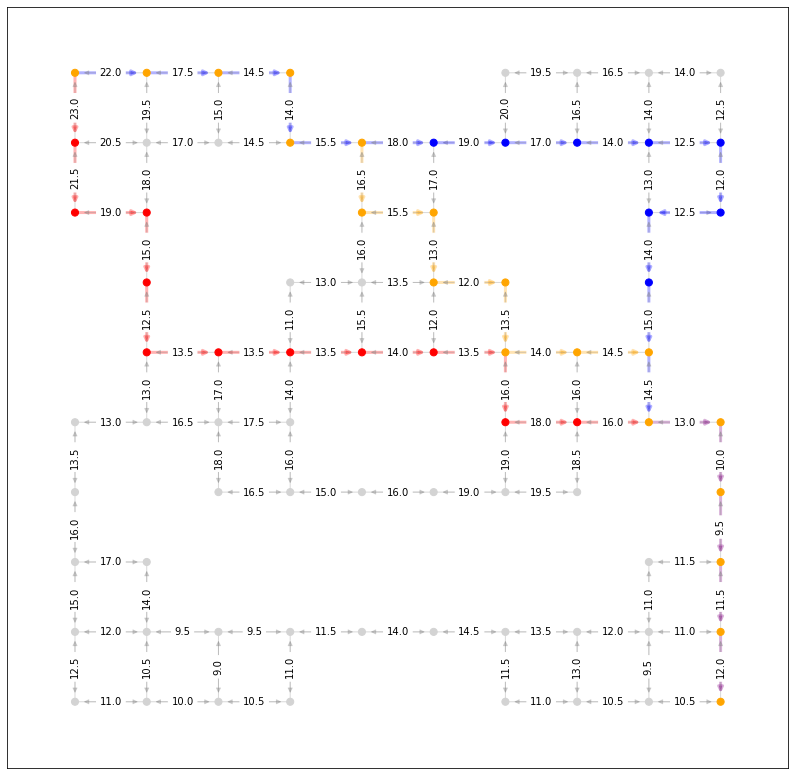

In [191]:
G = wtsToGraph(wts)
showGraph(G, (0,0), (9,9), paths=['bfs','dfs','ucs'], labels=False, gsize=(14,14), node_pos='project_layout')

# Generate your DQ 2 graph
Design your own mask array.

In [240]:
# Design your own array
project = np.array([
    [2,2,2,2,2],
    [4,6,1,1,2],
    [1,2,2,4,1],
    [2,2,1,2,4],
    [2,4,6,1,6]
],dtype=float) 

# Generate a random project (just uncomment and run)
project = genWeights(5, 5, 0, 15, radius=1, block_prob=0)

mask = np.array([
    [0,0,0,0,0],
    [0,1,0,1,0],
    [0,0,0,0,0],
    [1,0,0,0,1],
    [0,0,1,0,0],
])
project[mask == 1] = np.infty

Now display your array and graph.

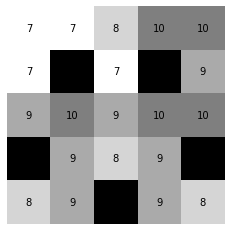

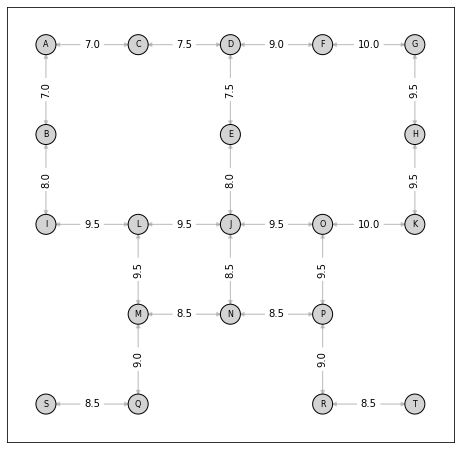

In [241]:
# Display project as grid
showProjectMatrix(project, save_file="proj_mat.png")

# Convert array into corresponding graph
G = wtsToGraph(project)
# Change labels to A-Z
alphabet = map(chr,range(65,91)) # Quick way to get alphabet
# Display graph
showGraph(G, (0,0), (4,4), labels=alphabet, gsize=(8,8), node_pos='project_layout', save_file="proj_graph.png")